# Path setup & import packages

In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.ws_regression import *
from datasets.imdb_tmdb_dataset import * 
from datasets.basic_clmn_dataset import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
seed = 42
feature_drop_cols = ['vote_average', 'imdbId', 'movieId','tmdbId']
label_feature = 'vote_average'

# Fully supervised

In [2]:
# read data
df = pd.read_csv(os.path.join(root_path, 'data',
                              'imdb-tmdb', 'merged_imdb_tmdb_with_additional_features.csv')).fillna(0)

X, Y = df.drop(feature_drop_cols, axis=1), df[label_feature]

# split data
train_fraction = 0.75
# # split data
indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
X_train = X.iloc[indices_train]
Y_train = Y[indices_train]
X_test = X.iloc[indices_test]
Y_test = Y[indices_test]

# model declaration and fit
model = Pipeline([
    ("std", StandardScaler()),
    ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
])
model.fit(X_train, Y_train)
Y_test_pred = model.predict(X_test)
true_mse = mean_squared_error(Y_test, Y_test_pred)
print('MSE', true_mse)

MSE 0.37324481674300336


# Weak Supervision

In [3]:
Y_mean = Y.mean() # centering for LF generation
Y_var = Y.var()

param_err, mu_err, score, mse = {}, {}, {}, {}

for m in range(3, 20):
    n = len(Y)
    L, true_Sigma = generate_lfs(m, n, Y - Y_mean, Y_var)

    lm = LabelModel()
    lm.fit(L, Y_var)
    lm.inference(L)
    Y_hat = lm.Y_hat + Y_mean

    
    Sigma_hat = lm.Sigma_hat
    param_err[m] = np.linalg.norm(Sigma_hat - true_Sigma) / (m+1)**2
    mu_err[m]    = np.linalg.norm(Sigma_hat[:m,m] - true_Sigma[:m,m]) / m
    score[m] = lm.score(Y - Y_mean)
    
    
    # # split data
    indices_train, indices_test = train_test_split(list(range(len(Y))), train_size=train_fraction, random_state=seed)
    X_train = X.iloc[indices_train]
    Y_train = Y_hat[indices_train]
    X_test = X.iloc[indices_test]
    Y_test = Y[indices_test]

    # model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_train)
    Y_test_pred = model.predict(X_test)
    mse[m] = mean_squared_error(Y_test, Y_test_pred)
    print('numLFs', m, 'MSE', mse[m])

numLFs 3 MSE 0.420558720959944
numLFs 4 MSE 0.39781855519826964
numLFs 5 MSE 0.38939525662571123
numLFs 6 MSE 0.3837076208994707
numLFs 7 MSE 0.40142654023313656
numLFs 8 MSE 0.3898483010820152
numLFs 9 MSE 0.377678715374821
numLFs 10 MSE 0.3820143378194598
numLFs 11 MSE 0.3725688103787865
numLFs 12 MSE 0.37702024879388807
numLFs 13 MSE 0.3739082825682077
numLFs 14 MSE 0.3813552897342545
numLFs 15 MSE 0.37905011805438127
numLFs 16 MSE 0.38407715361776223
numLFs 17 MSE 0.37599855486258277
numLFs 18 MSE 0.38751919770338966
numLFs 19 MSE 0.3842139527548395


# Fully supervision with small true

In [4]:
true_small_mse = {}

for sample_percent in range(10, 60, 10):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_fraction, random_state=seed)
    sample_size = int(len(X_train) * sample_percent / 100)
    np.random.seed(seed=seed)
    sample_indices = np.random.choice(list(range(len(X_train))), size=sample_size, replace=False)
    X_train = X_train.iloc[sample_indices]
    Y_train = Y_train.iloc[sample_indices]

    # model declaration and fit
    model = Pipeline([
        ("std", StandardScaler()),
        ("model", GradientBoostingRegressor(n_estimators=250, random_state=seed))
    ])
    model.fit(X_train, Y_train)
    
    Y_test_pred = model.predict(X_test)
    true_small_mse[sample_percent] = mean_squared_error(Y_test, Y_test_pred)
    print('sample_percent', sample_percent, 'MSE', true_small_mse[sample_percent])

sample_percent 10 MSE 0.7169598416536004
sample_percent 20 MSE 0.4575947403570384
sample_percent 30 MSE 0.502726724440344
sample_percent 40 MSE 0.3950616857874979
sample_percent 50 MSE 0.3997593122193608


# Result data handling

In [5]:
param_err = pd.Series(param_err)
mu_err = pd.Series(mu_err)
score = pd.Series(score)
mse = pd.Series(mse)

# Result visualization

[Text(0.5, 0, '# of LFs'),
 Text(0, 0.5, 'MSE'),
 Text(0.5, 1.0, 'End model performance')]

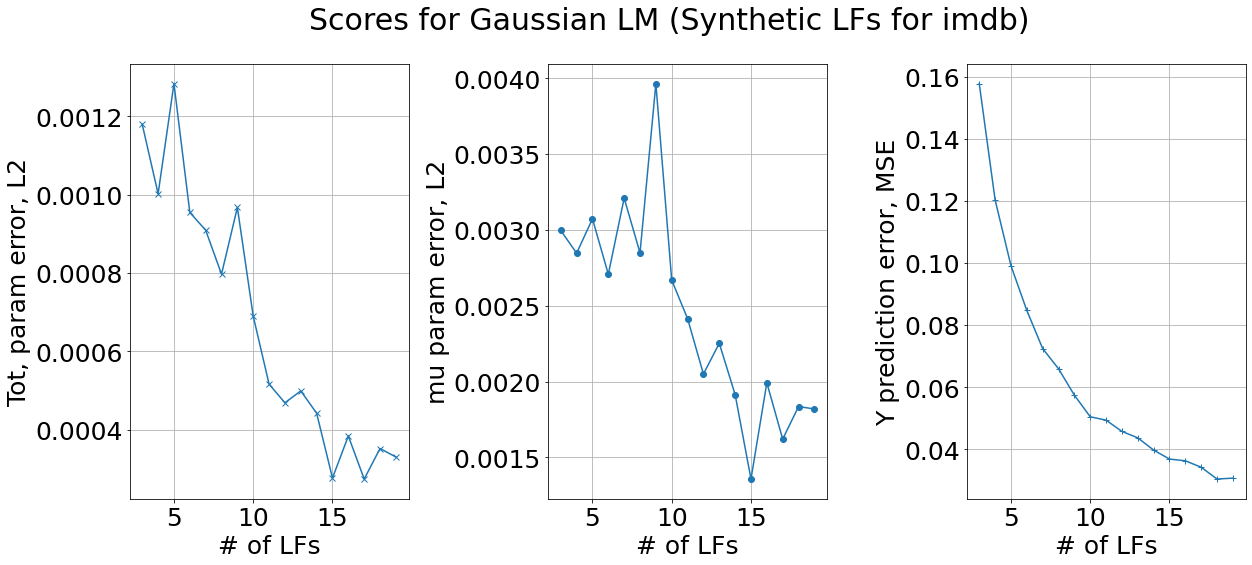

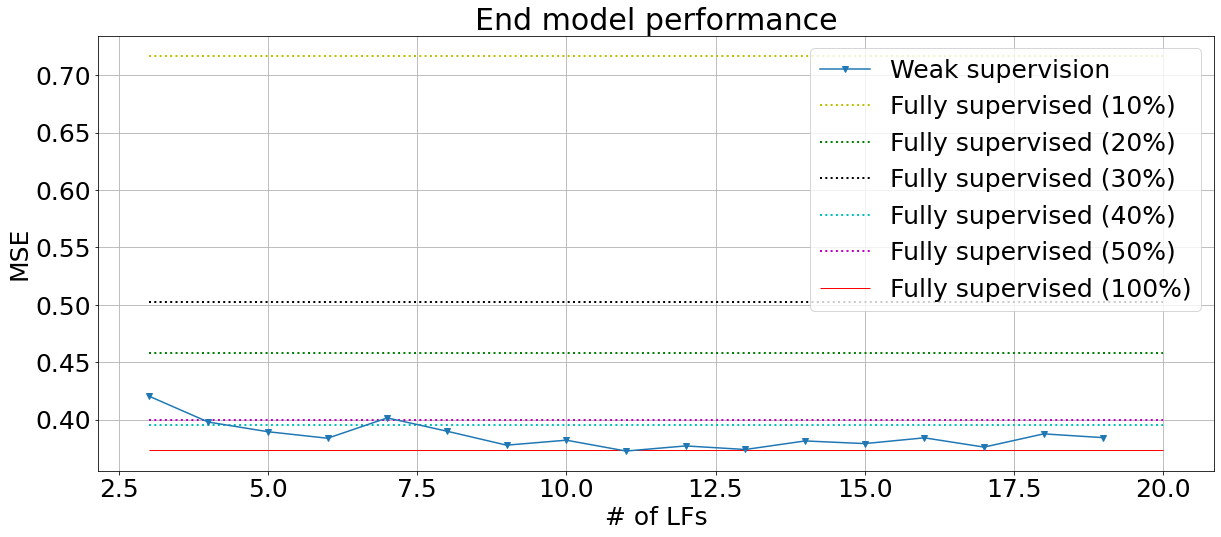

In [6]:
plt.rcParams['font.size'] = '25'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,8))

fig.suptitle('Scores for Gaussian LM (Synthetic LFs for imdb)')
ax1.plot(param_err, marker='x')
ax1.set(ylabel='Tot, param error, L2')
ax1.set(xlabel='# of LFs')
ax1.grid()
ax2.plot(mu_err, marker='o')
ax2.set(ylabel='mu param error, L2')
ax2.set(xlabel='# of LFs')
ax2.grid()
ax3.plot(score, marker='+')
ax3.set(ylabel='Y prediction error, MSE')
ax3.set(xlabel='# of LFs')
ax3.grid()
fig.subplots_adjust(wspace=.5)

fig, ax = plt.subplots(figsize=(20,8))
ax.plot(mse, marker='v', label='Weak supervision')
colors = ['y', 'g', 'k', 'c', 'm']
for i, sample_percent in enumerate(true_small_mse):
    ax.hlines(y=true_small_mse[sample_percent], linewidth=2, xmin=3, xmax=20, color=colors[i],
            linestyles='dotted', label=f'Fully supervised ({sample_percent}%)')
    
ax.hlines(y=true_mse, linewidth=1, xmin=3, xmax=20, color='r', label='Fully supervised (100%)')
ax.grid()
ax.legend()
ax.set(xlabel='# of LFs', ylabel='MSE', title='End model performance')